In [339]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [340]:
train=pd.read_csv('../input/titanic/train.csv')
test=pd.read_csv('../input/titanic/test.csv')
submission=pd.read_csv('../input/titanic/gender_submission.csv')

test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


# Visualisation des données

<AxesSubplot:>

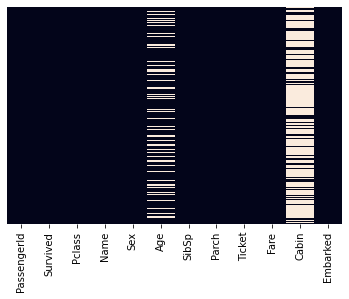

In [341]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.heatmap(train.isnull(),yticklabels=False,cbar=False)

On remarque qu'il y a énormément de données manquantes sur les cabines, on se débarassera donc de cette colonne plus tard car les données sont inexploitables. Il y a également des données manquantes concernant l'âge des passagers. On peut soit remplir ces données manquantes en calculant l'âge moyen des passagers, soit supprimer les lignes.

<AxesSubplot:>

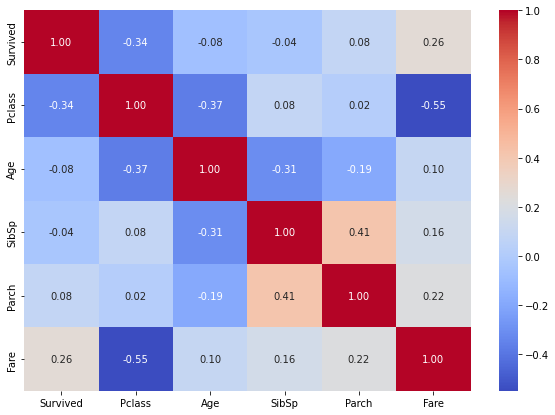

In [342]:
plt.figure(figsize=(10, 7))
sns.heatmap(train[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']].corr(), annot = True, fmt='.2f', cmap='coolwarm')

On remarque que la chance de survie d'un passager est corrélée à sa classe passager et au montant de son ticket.

<AxesSubplot:xlabel='Survived', ylabel='count'>

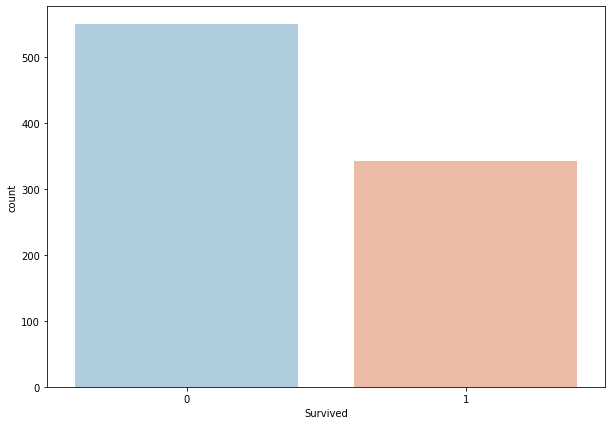

In [343]:
plt.figure(figsize=(10, 7))
sns.countplot(x='Survived',data=train,palette='RdBu_r')

Il y a plus de morts que de survivants.

<AxesSubplot:xlabel='Survived', ylabel='count'>

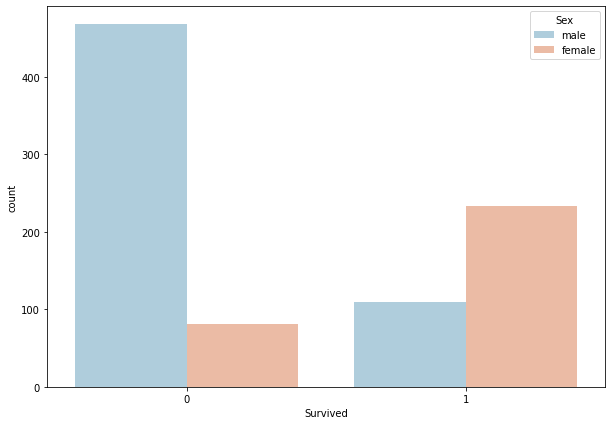

In [344]:
plt.figure(figsize=(10, 7))
sns.countplot(x='Survived',hue='Sex',data=train,palette='RdBu_r')

Les femmes ont plus de chances de survivre.

<AxesSubplot:xlabel='Survived', ylabel='count'>

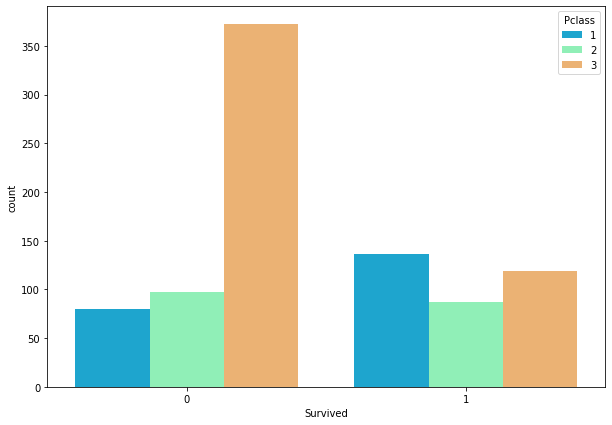

In [345]:
plt.figure(figsize=(10, 7))
sns.countplot(x='Survived',hue='Pclass',data=train,palette='rainbow')

Les passagers de troisième classe constituent la majorité des morts. Les premières classes sont majoritaires chez les survivants. Il y a a plus de survivants chez les troisièmes classes que les deuxièmes, ce qui est probablement dû au fait qu'ils soient plus nombreux.

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

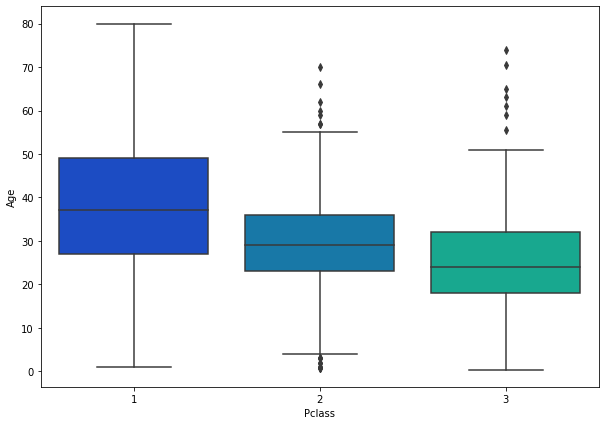

In [346]:
plt.figure(figsize=(10, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

Les premières classes sont les plus agées et les troisièmes les plus jeunes.

# Modification des données

On modifie les données pour faciliter l'analyse. On transforme les données catégorielles (qualitatives) en données numériques (quantitatives) pour faciliter les calculs sur ces données. 

In [347]:
# On se débarasse des colonnes inutiles
train = train.drop(['PassengerId','Name','Ticket', 'Cabin'], axis=1)
test = test.drop(['Name','Ticket', 'Cabin'], axis=1)

# On convertit les données catégorielles

# Embarcation
train_embark = pd.get_dummies(train['Embarked'])
test_embark = pd.get_dummies(test['Embarked'])

train.drop(['Embarked'],axis=1,inplace=True)
test.drop(['Embarked'],axis=1,inplace=True)

train = pd.concat([train,train_embark],axis=1)
test = pd.concat([test, test_embark], axis=1)

# Sexe
sex_train = pd.get_dummies(train['Sex'],drop_first=True)
sex_test = pd.get_dummies(test['Sex'], drop_first=True)

train.drop(['Sex'],axis=1,inplace=True)
test.drop(['Sex'],axis=1,inplace=True)

train = pd.concat([train,sex_train],axis=1)
test = pd.concat([test, sex_test], axis=1)

# On supprime les lignes avec des valeurs manquantes
train = train.dropna()
test = test.dropna()


train.info()
print("-----------------------------------------")
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  714 non-null    int64  
 1   Pclass    714 non-null    int64  
 2   Age       714 non-null    float64
 3   SibSp     714 non-null    int64  
 4   Parch     714 non-null    int64  
 5   Fare      714 non-null    float64
 6   C         714 non-null    uint8  
 7   Q         714 non-null    uint8  
 8   S         714 non-null    uint8  
 9   male      714 non-null    uint8  
dtypes: float64(2), int64(4), uint8(4)
memory usage: 41.8 KB
-----------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 331 entries, 0 to 415
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  331 non-null    int64  
 1   Pclass       331 non-null    int64  
 2   Age          331 non-null    float64
 3   SibS

# Séparation des données en deux sous-ensembles pour les tests et l'apprentissage

In [348]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

train_X = train.drop('Survived', axis=1)
train_y = train['Survived']
test_X = test.drop('PassengerId', axis=1)

test = pd.merge(test, submission, on='PassengerId')
test_y = test.Survived

# RandomForestRegressor

In [349]:
from sklearn.ensemble import RandomForestRegressor


model = RandomForestRegressor(random_state=31)
model.fit(train_X, train_y)

test_predictions = model.predict(test_X)

# 
print("Score : " + str(model.score(train_X, train_y)) + " | mae : " + str(mean_absolute_error(test_y, test_predictions)))


Score : 0.8934188636997707 | mae : 0.23706689684937418


On obtient de moins bons résultats sur un jeu de données différent de celui utilisé pour l'entrainement, dû à l'overfitting.

# RandomForestClassifier

In [350]:
from sklearn.ensemble import RandomForestClassifier


model = RandomForestClassifier(random_state=31)
model.fit(train_X, train_y)

test_predictions = model.predict(test_X)

print("Score : " + str(model.score(train_X, train_y)) + " | accuracy score : " + str(accuracy_score(test_y, test_predictions)))


Score : 0.9859943977591037 | accuracy score : 0.8096676737160121


# LinearRegression

In [351]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(train_X, train_y)

test_predictions = model.predict(test_X)
model.score(train_X, train_y)

0.40343419083914367

# LogisticRegression

In [352]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=31, solver='liblinear')
model.fit(train_X, train_y)

test_predictions = model.predict(test_X)
model.score(train_X, train_y)

0.7969187675070029

# Support Vector Machines

In [353]:
from sklearn.svm import SVC

model = SVC()
model.fit(train_X, train_y)

test_predictions = model.predict(test_X)
model.score(train_X, train_y)

0.6778711484593838

# KNeighborsClassifier

In [354]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors = 2)
model.fit(train_X, train_y)

test_predictions = model.predict(test_X)
model.score(train_X, train_y)

0.8235294117647058

# Gaussian Naive Bayes

In [355]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(train_X, train_y)

test_predictions = model.predict(test_X)
model.score(train_X, train_y)

0.7717086834733894

# Gradient Boosting Classifier

In [356]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=131)
model.fit(train_X, train_y)

test_predictions = model.predict(test_X)
model.score(train_X, train_y)

0.9131652661064426